<a href="https://colab.research.google.com/github/Uma-kanagarajan/Gender-Prediction/blob/main/name_gender_prediction_keras_tuner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import necessary libraries

In [ ]:
pip install keras-tuner --upgrade

     |████████████████████████████████| 98 kB 3.5 MB/s 


In [2]:
#import all the necessary libraries

import os

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
#import keras_tuner as kt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")


### Load the dataset

In [6]:
# load and preview the data

names_df = pd.read_csv('name_gender.csv')
names_df.head()

,name,gender
0,Aaban&&,M
1,Aabha*,F
2,Aabid,M
3,Aabriella,F
4,Aada_,F


In [7]:
print("The Shape of the dataset: ", names_df.shape)
print("The Columns of the dataset are ", names_df.columns)
print("Any missing values in the dataset ", names_df.isnull().sum())
print("Unique value counts for the gender variable :", names_df['gender'].value_counts())

The Shape of the dataset:  (95025, 2)
The Columns of the dataset are  Index(['name', 'gender'], dtype='object')
Any missing values in the dataset  name      0
gender    0
dtype: int64
Unique value counts for the gender variable : F    60304
M    34721
Name: gender, dtype: int64


### Preprocess the dataset

In [8]:
#define a function to preprocess the data.

''' 
This function takes names as input and converts it into an array using below steps.
1. Removes non-alphabetical characters and spaces from the given input name.
2. Then tokenize each characters of the name into a vector and converts it into an integer
3. Given name length gets changed to a fixed length of 20 with the help of post padded sequence

Input Parameter: name(string/list of strings)

Function output: name array

'''

def preprocess_name(names_df):
  names_df['name'] = names_df['name'].str.replace('[^a-zA-Z]', '') #remove unncessary characters
  names = names_df['name'].values 
  tokenizer = Tokenizer(num_words=None, oov_token=oov_tok, char_level=True) # Character splitting in tokenizer
  tokenizer.fit_on_texts(names)   #Train the corpus
  sequences = tokenizer.texts_to_sequences(names)  #convert character to integer
  name_length = 20
  input_sequences = pad_sequences(sequences, maxlen=name_length, padding='post')  #padding
  #input_array = np.asarray(input_sequences) 

  return input_sequences

### Model definition

In [9]:
# function for model definition

''' 

This function defines a model with sequential API with the layers such as
Embedding, LSTM, Dropout, Dense and a final dense output layer.
Optimizer: Adam
Loss: Binary crossentropy.

Input Parameter: Input dimension, output dimension and input length for embedding layer

Function output: Model

'''

def lstm_model(num_alphabets, embedding_dim, name_length):
    model = Sequential([
        Embedding(num_alphabets, embedding_dim, input_length=name_length),
        #Bidirectional(LSTM(units=32, recurrent_dropout=0.2, dropout=0.2)),
        Bidirectional(LSTM(units=32)),
        Dropout(0.2),
        Dense(units=32, activation='relu'),
        Dense(1, activation="sigmoid")
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.01),
                  metrics=['accuracy'])

    return model

### Model Building

In [10]:
oov_tok = "<OOV>"

#Step 1: Preprocess the input features(names)
X = preprocess_name(names_df)

# Step 2: Get labels
#Label Encoder
le = preprocessing.LabelEncoder()
names_df['gender'] = le.fit_transform(names_df['gender'])
y = np.asarray(names_df['gender'].values.tolist())


# Step 3: Split Training and Test Data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=0)

# Step 4: Instantiate the model
model = lstm_model(num_alphabets=28, embedding_dim=28, name_length=20)

In [11]:
#Step 5 : Train the model
callbacks = [
    EarlyStopping(monitor='val_accuracy',
                  min_delta=1e-3,
                  patience=5,
                  mode='max',
                  restore_best_weights=True,
                  verbose=1),
]

history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=128,
                    epochs=200,
                    validation_data=(X_test, y_test),
                    callbacks=[callbacks])


# Step 6: Save the model
model.save('gender_prediction.h5')


Epoch 1/200
594/594 [==============================] - 19s 17ms/step - loss: 0.4027 - accuracy: 0.8194 - val_loss: 0.3495 - val_accuracy: 0.8498
Epoch 2/200
594/594 [==============================] - 9s 15ms/step - loss: 0.3380 - accuracy: 0.8568 - val_loss: 0.3298 - val_accuracy: 0.8602
Epoch 3/200
594/594 [==============================] - 9s 15ms/step - loss: 0.3124 - accuracy: 0.8683 - val_loss: 0.2949 - val_accuracy: 0.8739
Epoch 4/200
594/594 [==============================] - 9s 16ms/step - loss: 0.2927 - accuracy: 0.8771 - val_loss: 0.2865 - val_accuracy: 0.8779
Epoch 5/200
594/594 [==============================] - 9s 16ms/step - loss: 0.2835 - accuracy: 0.8822 - val_loss: 0.2786 - val_accuracy: 0.8850
Epoch 6/200
594/594 [==============================] - 9s 16ms/step - loss: 0.2754 - accuracy: 0.8859 - val_loss: 0.2783 - val_accuracy: 0.8843
Epoch 7/200
594/594 [==============================] - 9s 15ms/step - loss: 0.2701 - accuracy: 0.8881 - val_loss: 0.2713 - val_accuracy

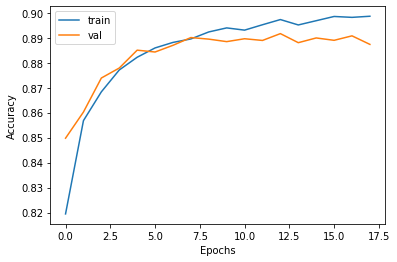

In [12]:
#Step 7: Visualize the model accuracies

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

### Model Evaluation

In [14]:
model.evaluate(X_train, y_train)

2376/2376 [==============================] - 14s 6ms/step - loss: 0.2308 - accuracy: 0.9052


[0.23082274198532104, 0.9052486419677734]

In [13]:
#function for model evaluation

"""
This function evaluates the model for the test data and shows the result in a datafram.

Input Parameter: Model, X_test, y_test

Function output: Evaluation Dataframe

"""

def evaluate_model(model, X_test, y_test):
  
    eval_dict = model.evaluate(X_test, y_test, return_dict=True)
    display_df = pd.DataFrame([eval_dict.values()], columns=[list(eval_dict.keys())])
    return display_df

# Evaluate model on test set and add results to dataframe
results = evaluate_model(model, X_test, y_test)

# Set index to 'Baseline'
results.index = ['Baseline']

# Display results
results.head()

594/594 [==============================] - 4s 6ms/step - loss: 0.2687 - accuracy: 0.8917


,loss,accuracy
Baseline,0.268744,0.89166


### Model Prediction

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
name = ['Mark', 'Rosie', 'Andrew', 'Antony', 'Pooja', 'Xin Yang', 'Fei', 'Albert', 'Chun Hua', 'rita']

# Convert to dataframe
pred_df = pd.DataFrame({'name': name})

# Preprocess the given names
name_array = preprocess_name(pred_df)

# Prediction
predict_x = model.predict(name_array)
gender_list = []
for i in predict_x:
  if i >0.5:
    gender_list.append('Male')
  else:
    gender_list.append('Female')


# Format the output
pred_df['name'] = name
pred_df.rename(columns={'name': 'Name'}, inplace=True)
pred_df['Gender'] = gender_list
pred_df['Probability'] = predict_x.round(2)
pred_df.drop_duplicates(inplace=True)

pred_df

### Keras Tuner

Build a hypermodel

In [ ]:
"""
Builds model and sets up hyperparameter space to search.

Input Parameter: HyperParameter object

Function output: Model

"""
def build_model(hp):
  
  #Initialize value for embedding layer
  num_alphabets=28
  name_length=20

  # Initialize sequential API and start building model.
  model = keras.Sequential()
  
  # Tune Embedding layer with values between 16 to 32 with a stepsize of 8.
  model.add(Embedding(num_alphabets,
                      output_dim=hp.Int("output_dim", min_value=16, max_value=32, step=8),
                      input_length = name_length)
  )

  # Tune LSTM layer with values between 16 to 64 with a stepsize of 16.
  model.add(Bidirectional(LSTM(units=hp.Int("LSTM_units", min_value=16, max_value=64, step=16))))

  # Tune Dropout layer with values betwen 0.1 to 0.3 with a stepsize of 0.1.
  model.add(Dropout(hp.Float('Dropout_rate',min_value=0.1,max_value=0.3,step=0.1)))

  # Tune Dense layer with values between 16 to 40 with a stepsize of 8.
  model.add(Dense(units=hp.Int("units_", min_value=16, max_value=40, step=8),activation="relu"))
  
  # Add output layer.
  model.add(Dense(units=1, activation="sigmoid"))
  
  # Tune learning rate for Adam optimizer with values among 0.1, 0.01, or 0.001
  hp_learning_rate = hp.Choice("learning_rate", values=[1e-1, 1e-2, 1e-3])

  # Define optimizer, loss, and metrics
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='binary_crossentropy',
                metrics=["accuracy"])
  
  return model


In [ ]:

# Instantiate the tuner
tuner = kt.Hyperband(build_model,
                     objective="val_accuracy",
                     max_epochs=20,
                     factor=3,
                     hyperband_iterations=10,
                     directory="kt_dir",
                     project_name="kt_hyperband",
                     overwrite=True)

In [ ]:
# Display search space summary
tuner.search_space_summary()

Search space summary
Default search space size: 5
output_dim (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 32, 'step': 8, 'sampling': None}
LSTM_units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': None}
Dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.3, 'step': 0.1, 'sampling': None}
units_ (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 40, 'step': 8, 'sampling': None}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001], 'ordered': True}


In [ ]:
callbacks = [
    EarlyStopping(monitor='val_accuracy',
                  min_delta=1e-3,
                  patience=5,
                  mode='max',
                  restore_best_weights=True,
                  verbose=1),
]

tuner.search(X_train, y_train, epochs=20, validation_data=(X_test, y_test), callbacks=[callbacks], verbose=2, batch_size=128)


Trial 300 Complete [00h 01m 05s]
val_accuracy: 0.82420414686203

Best val_accuracy So Far: 0.9012365341186523
Total elapsed time: 06h 05m 55s
INFO:tensorflow:Oracle triggered exit


In [ ]:

# Get the optimal hyperparameters from the results
best_hps=tuner.get_best_hyperparameters()[0]

# Build model
h_model = tuner.hypermodel.build(best_hps)

callbacks = [
    EarlyStopping(monitor='val_accuracy',
                  min_delta=1e-3,
                  patience=5,
                  mode='max',
                  restore_best_weights=True,
                  verbose=1),
]

# Train the hypertuned model
h_model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), callbacks=[callbacks], verbose=2, batch_size=128)


In [ ]:

# Evaluate model on test set
hyper_df = evaluate_model(h_model, X_test, y_test)

# Set index to hypertuned
hyper_df.index = ["Hypertuned"]

# Append results in dataframe
results.append(hyper_df)